#Generative Adversarial Networks

This colab is a highly modified version of [this blog post](https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3)., by Renu Khandelwal. For a beautiful illustration of how GANs work, see also this [interactive demonstration](https://poloclub.github.io/ganlab/).

A Generative Adversarial Network (GAN) is an unsupervised deep learning algorithm where a "Generator" Network is pitted against an adversarial network, called the "Discriminator.""

The role of the Generator is to create new objects similar to those in a set of training data. For this colab the training data will come from the MNIST images of handwritten numerals. Our Generator that we create will produce images similar to those. 

The role of the Discriminator is to distinguish between images that are not in our training set (including random noise), and those that are. 

The strategry of a GAN is to put these together, and alternately train them. We ask the Generator to produce an image, and train the Discriminator to recognize that this is artificially constructed (i.e. it did not come from the training set). We then ask the Generator to refine its output so that the Discriminator is fooled. Then we go back to training the Discriminator, and repeat.

BEFORE STARING THIS COLAB, ENABLE GPU RUNTIME.

We begin by importing all required libraries.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.optimizers import adam

Using TensorFlow backend.


We now loading the data from the MNIST dataset. 

In [48]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5)/127.5

# convert shape of x_train from (60000, 28, 28) to (60000, 784) 
# 784 columns per row
X_train = x_train.reshape(60000, 784)

X_train.shape

(60000, 784)

We create Generator as a sequence of dense layers.

In [3]:
generator=Sequential([
    Dense(units=256,input_dim=100,activation='relu'),
    Dense(units=512, activation='relu'),
    Dense(units=1024, activation='relu'),
    Dense(units=784, activation='tanh'),
])

generator.summary()
    
generator.compile(loss='binary_crossentropy', optimizer=adam(lr=0.0002, beta_1=0.5))


W0723 17:11:40.799869 140304807331712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 17:11:40.828660 140304807331712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 17:11:40.837840 140304807331712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 17:11:40.924229 140304807331712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 17:11:40.934401 140304807331712 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
_________________________________________________________________


The Discriminator is also a sequence of dense layers. The input will have shape (784,) (originally coming from a 28x28 image), and the output will be a number between 0 and 1, representing the confidence of the Discriminator that its input is "genuine" (i.e. from the training set).

In [4]:
##model building
discriminator = Sequential([
    Dense(1024, activation='relu',input_dim=784),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


discriminator.compile(loss='binary_crossentropy', optimizer=adam(lr=0.0002, beta_1=0.5))

discriminator.summary()

W0723 17:11:46.246182 140304807331712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 17:11:46.258702 140304807331712 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total para

We now create the GAN where we combine the Generator and Discriminator. When we train the Generator we will freeze the Discriminator.

We will input the noised image of shape 100 units to the Generator. The output generated from the Generator will be fed to the Discriminator.

In [5]:
#When we train the GAN that we are about to create, we will freeze the parameters of the Discriminator. 
#It is not necessary to do this now, but it will help us determine how many parameters there are at training time.
discriminator.trainable=False 

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_output= discriminator(x)
gan= Model(inputs=gan_input, outputs=gan_output)

gan.summary()

gan.compile(loss='binary_crossentropy', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


Before we start training the model, we will write a function plot_generated_images to plot the generated images. This way we can see how the images are generated. We save the generated images to file that we can view later

In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], cmap='gray', interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

We finally start to train GAN. 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1


  4%|▍         | 4/100 [00:00<00:02, 39.76it/s]

Epoch 2


  5%|▌         | 5/100 [00:00<00:02, 37.67it/s]

Epoch 3


  5%|▌         | 5/100 [00:00<00:02, 43.44it/s]

Epoch 4


  5%|▌         | 5/100 [00:00<00:02, 42.13it/s]

Epoch 5


  4%|▍         | 4/100 [00:00<00:02, 39.17it/s]

Epoch 6


  5%|▌         | 5/100 [00:00<00:02, 42.95it/s]

Epoch 7


  5%|▌         | 5/100 [00:00<00:02, 44.58it/s]

Epoch 8


  5%|▌         | 5/100 [00:00<00:02, 43.09it/s]

Epoch 9


  5%|▌         | 5/100 [00:00<00:02, 42.34it/s]

Epoch 10


  5%|▌         | 5/100 [00:00<00:02, 42.62it/s]

Epoch 11


  5%|▌         | 5/100 [00:00<00:02, 41.36it/s]

Epoch 12


  5%|▌         | 5/100 [00:00<00:02, 43.33it/s]

Epoch 13


  5%|▌         | 5/100 [00:00<00:02, 42.84it/s]

Epoch 14


  5%|▌         | 5/100 [00:00<00:02, 42.88it/s]

Epoch 15


  5%|▌         | 5/100 [00:00<00:02, 43.11it/s]

Epoch 16


  5%|▌         | 5/100 [00:00<00:02, 41.76it/s]

Epoch 17


  5%|▌         | 5/100 [00:00<00:02, 43.66it/s]

Epoch 18


  4%|▍         | 4/100 [00:00<00:02, 37.58it/s]

Epoch 19


  5%|▌         | 5/100 [00:00<00:02, 42.60it/s]

Epoch 20


  5%|▌         | 5/100 [00:00<00:02, 42.04it/s]

Epoch 21


  5%|▌         | 5/100 [00:00<00:02, 42.76it/s]

Epoch 22


  5%|▌         | 5/100 [00:00<00:02, 43.74it/s]

Epoch 23


  5%|▌         | 5/100 [00:00<00:02, 42.82it/s]

Epoch 24


  5%|▌         | 5/100 [00:00<00:02, 43.70it/s]

Epoch 25


  4%|▍         | 4/100 [00:00<00:02, 39.54it/s]

Epoch 26


  5%|▌         | 5/100 [00:00<00:02, 40.58it/s]

Epoch 27


  5%|▌         | 5/100 [00:00<00:02, 43.21it/s]

Epoch 28


  4%|▍         | 4/100 [00:00<00:02, 38.76it/s]

Epoch 29


  5%|▌         | 5/100 [00:00<00:02, 42.96it/s]

Epoch 30


  5%|▌         | 5/100 [00:00<00:02, 42.72it/s]

Epoch 31


  5%|▌         | 5/100 [00:00<00:02, 39.86it/s]

Epoch 32


  5%|▌         | 5/100 [00:00<00:02, 42.87it/s]

Epoch 33


  5%|▌         | 5/100 [00:00<00:02, 40.88it/s]

Epoch 34


  5%|▌         | 5/100 [00:00<00:02, 43.18it/s]

Epoch 35


  5%|▌         | 5/100 [00:00<00:02, 42.31it/s]

Epoch 36


  5%|▌         | 5/100 [00:00<00:02, 44.05it/s]

Epoch 37


  5%|▌         | 5/100 [00:00<00:02, 43.11it/s]

Epoch 38


  5%|▌         | 5/100 [00:00<00:02, 42.64it/s]

Epoch 39


  5%|▌         | 5/100 [00:00<00:02, 43.86it/s]

Epoch 40


  5%|▌         | 5/100 [00:00<00:02, 40.88it/s]

Epoch 41


  4%|▍         | 4/100 [00:00<00:02, 38.39it/s]

Epoch 42


  5%|▌         | 5/100 [00:00<00:02, 41.97it/s]

Epoch 43


  5%|▌         | 5/100 [00:00<00:02, 42.61it/s]

Epoch 44


  5%|▌         | 5/100 [00:00<00:02, 43.19it/s]

Epoch 45


  5%|▌         | 5/100 [00:00<00:02, 43.23it/s]

Epoch 46


  5%|▌         | 5/100 [00:00<00:02, 43.34it/s]

Epoch 47


  5%|▌         | 5/100 [00:00<00:02, 43.65it/s]

Epoch 48


  5%|▌         | 5/100 [00:00<00:02, 42.81it/s]

Epoch 49


  5%|▌         | 5/100 [00:00<00:02, 43.13it/s]

Epoch 50


  5%|▌         | 5/100 [00:00<00:02, 42.47it/s]

Epoch 51


  5%|▌         | 5/100 [00:00<00:02, 41.55it/s]

Epoch 52


  5%|▌         | 5/100 [00:00<00:02, 42.50it/s]

Epoch 53


  5%|▌         | 5/100 [00:00<00:02, 43.93it/s]

Epoch 54


  5%|▌         | 5/100 [00:00<00:02, 43.06it/s]

Epoch 55


  5%|▌         | 5/100 [00:00<00:02, 43.89it/s]

Epoch 56


  5%|▌         | 5/100 [00:00<00:02, 43.82it/s]

Epoch 57


  5%|▌         | 5/100 [00:00<00:02, 41.52it/s]

Epoch 58


  5%|▌         | 5/100 [00:00<00:02, 42.21it/s]

Epoch 59


  4%|▍         | 4/100 [00:00<00:02, 38.74it/s]

Epoch 60


  5%|▌         | 5/100 [00:00<00:02, 41.59it/s]

Epoch 61


  4%|▍         | 4/100 [00:00<00:02, 38.27it/s]

Epoch 62


  5%|▌         | 5/100 [00:00<00:02, 43.18it/s]

Epoch 63


  5%|▌         | 5/100 [00:00<00:02, 43.43it/s]

Epoch 64


  5%|▌         | 5/100 [00:00<00:02, 42.94it/s]

Epoch 65


  5%|▌         | 5/100 [00:00<00:02, 43.89it/s]

Epoch 66


  5%|▌         | 5/100 [00:00<00:02, 42.84it/s]

Epoch 67


  5%|▌         | 5/100 [00:00<00:02, 43.09it/s]

Epoch 68


  5%|▌         | 5/100 [00:00<00:02, 41.02it/s]

Epoch 69


  5%|▌         | 5/100 [00:00<00:02, 40.83it/s]

Epoch 70


  4%|▍         | 4/100 [00:00<00:02, 39.09it/s]

Epoch 71


  5%|▌         | 5/100 [00:00<00:02, 41.37it/s]

Epoch 72


  5%|▌         | 5/100 [00:00<00:02, 42.73it/s]

Epoch 73


  5%|▌         | 5/100 [00:00<00:02, 42.05it/s]

Epoch 74


  5%|▌         | 5/100 [00:00<00:02, 43.01it/s]

Epoch 75


  5%|▌         | 5/100 [00:00<00:02, 43.19it/s]

Epoch 76


  4%|▍         | 4/100 [00:00<00:02, 38.32it/s]

Epoch 77


  5%|▌         | 5/100 [00:00<00:02, 41.48it/s]

Epoch 78


  5%|▌         | 5/100 [00:00<00:02, 43.77it/s]

Epoch 79


  5%|▌         | 5/100 [00:00<00:02, 41.90it/s]

Epoch 80


  5%|▌         | 5/100 [00:00<00:02, 42.86it/s]

Epoch 81


  5%|▌         | 5/100 [00:00<00:02, 42.66it/s]

Epoch 82


  5%|▌         | 5/100 [00:00<00:02, 43.21it/s]

Epoch 83


  5%|▌         | 5/100 [00:00<00:02, 42.43it/s]

Epoch 84


  5%|▌         | 5/100 [00:00<00:02, 42.83it/s]

Epoch 85


  5%|▌         | 5/100 [00:00<00:02, 42.82it/s]

Epoch 86


  5%|▌         | 5/100 [00:00<00:02, 43.75it/s]

Epoch 87


  4%|▍         | 4/100 [00:00<00:02, 38.35it/s]

Epoch 88


  5%|▌         | 5/100 [00:00<00:02, 43.25it/s]

Epoch 89


  5%|▌         | 5/100 [00:00<00:02, 44.24it/s]

Epoch 90


  4%|▍         | 4/100 [00:00<00:02, 39.85it/s]

Epoch 91


  5%|▌         | 5/100 [00:00<00:02, 43.32it/s]

Epoch 92


  5%|▌         | 5/100 [00:00<00:02, 42.74it/s]

Epoch 93


  5%|▌         | 5/100 [00:00<00:02, 41.64it/s]

Epoch 94


  5%|▌         | 5/100 [00:00<00:02, 43.84it/s]

Epoch 95


  5%|▌         | 5/100 [00:00<00:02, 43.10it/s]

Epoch 96


  5%|▌         | 5/100 [00:00<00:02, 43.11it/s]

Epoch 97


  5%|▌         | 5/100 [00:00<00:02, 41.97it/s]

Epoch 98


  5%|▌         | 5/100 [00:00<00:02, 43.87it/s]

Epoch 99


  4%|▍         | 4/100 [00:00<00:02, 38.50it/s]

Epoch 100


  4%|▍         | 4/100 [00:00<00:02, 39.85it/s]

Epoch 101


  5%|▌         | 5/100 [00:00<00:02, 43.57it/s]

Epoch 102


  4%|▍         | 4/100 [00:00<00:02, 38.34it/s]

Epoch 103


  5%|▌         | 5/100 [00:00<00:02, 41.09it/s]

Epoch 104


  5%|▌         | 5/100 [00:00<00:02, 43.04it/s]

Epoch 105


  5%|▌         | 5/100 [00:00<00:02, 43.30it/s]

Epoch 106


  5%|▌         | 5/100 [00:00<00:02, 42.03it/s]

Epoch 107


  5%|▌         | 5/100 [00:00<00:02, 43.04it/s]

Epoch 108


  5%|▌         | 5/100 [00:00<00:02, 42.94it/s]

Epoch 109


  5%|▌         | 5/100 [00:00<00:02, 42.39it/s]

Epoch 110


  5%|▌         | 5/100 [00:00<00:02, 43.41it/s]

Epoch 111


  5%|▌         | 5/100 [00:00<00:02, 43.57it/s]

Epoch 112


  5%|▌         | 5/100 [00:00<00:02, 43.26it/s]

Epoch 113


  4%|▍         | 4/100 [00:00<00:02, 39.72it/s]

Epoch 114


  5%|▌         | 5/100 [00:00<00:02, 41.96it/s]

Epoch 115


  5%|▌         | 5/100 [00:00<00:02, 43.58it/s]

Epoch 116


  5%|▌         | 5/100 [00:00<00:02, 43.30it/s]

Epoch 117


  5%|▌         | 5/100 [00:00<00:02, 43.78it/s]

Epoch 118


  5%|▌         | 5/100 [00:00<00:02, 42.00it/s]

Epoch 119


  5%|▌         | 5/100 [00:00<00:02, 43.25it/s]

Epoch 120


  5%|▌         | 5/100 [00:00<00:02, 41.72it/s]

Epoch 121


  4%|▍         | 4/100 [00:00<00:02, 39.56it/s]

Epoch 122


  5%|▌         | 5/100 [00:00<00:02, 43.98it/s]

Epoch 123


  5%|▌         | 5/100 [00:00<00:02, 44.32it/s]

Epoch 124


  5%|▌         | 5/100 [00:00<00:02, 43.06it/s]

Epoch 125


  5%|▌         | 5/100 [00:00<00:02, 43.09it/s]

Epoch 126


  5%|▌         | 5/100 [00:00<00:02, 41.98it/s]

Epoch 127


  4%|▍         | 4/100 [00:00<00:02, 39.48it/s]

Epoch 128


  5%|▌         | 5/100 [00:00<00:02, 41.46it/s]

Epoch 129


  5%|▌         | 5/100 [00:00<00:02, 41.68it/s]

Epoch 130


  5%|▌         | 5/100 [00:00<00:02, 42.74it/s]

Epoch 131


  5%|▌         | 5/100 [00:00<00:02, 43.65it/s]

Epoch 132


  5%|▌         | 5/100 [00:00<00:02, 43.50it/s]

Epoch 133


  5%|▌         | 5/100 [00:00<00:02, 43.73it/s]

Epoch 134


  5%|▌         | 5/100 [00:00<00:02, 41.48it/s]

Epoch 135


  5%|▌         | 5/100 [00:00<00:02, 43.94it/s]

Epoch 136


  5%|▌         | 5/100 [00:00<00:02, 43.03it/s]

Epoch 137


  5%|▌         | 5/100 [00:00<00:02, 43.03it/s]

Epoch 138


  5%|▌         | 5/100 [00:00<00:02, 43.67it/s]

Epoch 139


  5%|▌         | 5/100 [00:00<00:02, 43.45it/s]

Epoch 140


  4%|▍         | 4/100 [00:00<00:02, 38.28it/s]

Epoch 141


  5%|▌         | 5/100 [00:00<00:02, 43.36it/s]

Epoch 142


  5%|▌         | 5/100 [00:00<00:02, 42.65it/s]

Epoch 143


  5%|▌         | 5/100 [00:00<00:02, 43.94it/s]

Epoch 144


  5%|▌         | 5/100 [00:00<00:02, 42.38it/s]

Epoch 145


  5%|▌         | 5/100 [00:00<00:02, 41.74it/s]

Epoch 146


  5%|▌         | 5/100 [00:00<00:02, 43.25it/s]

Epoch 147


  5%|▌         | 5/100 [00:00<00:02, 43.05it/s]

Epoch 148


  5%|▌         | 5/100 [00:00<00:02, 41.35it/s]

Epoch 149


  4%|▍         | 4/100 [00:00<00:02, 39.35it/s]

Epoch 150


  5%|▌         | 5/100 [00:00<00:02, 42.66it/s]

Epoch 151


  5%|▌         | 5/100 [00:00<00:02, 41.60it/s]

Epoch 152


  5%|▌         | 5/100 [00:00<00:02, 40.15it/s]

Epoch 153


  5%|▌         | 5/100 [00:00<00:02, 42.77it/s]

Epoch 154


  5%|▌         | 5/100 [00:00<00:02, 39.39it/s]

Epoch 155


  5%|▌         | 5/100 [00:00<00:02, 41.93it/s]

Epoch 156


  5%|▌         | 5/100 [00:00<00:02, 41.36it/s]

Epoch 157


  5%|▌         | 5/100 [00:00<00:02, 41.13it/s]

Epoch 158


  5%|▌         | 5/100 [00:00<00:02, 41.31it/s]

Epoch 159


  5%|▌         | 5/100 [00:00<00:02, 40.11it/s]

Epoch 160


  4%|▍         | 4/100 [00:00<00:02, 36.94it/s]

Epoch 161


  4%|▍         | 4/100 [00:00<00:02, 37.36it/s]

Epoch 162


  5%|▌         | 5/100 [00:00<00:02, 42.69it/s]

Epoch 163


  5%|▌         | 5/100 [00:00<00:02, 41.88it/s]

Epoch 164


  4%|▍         | 4/100 [00:00<00:02, 38.07it/s]

Epoch 165


  5%|▌         | 5/100 [00:00<00:02, 43.55it/s]

Epoch 166


  5%|▌         | 5/100 [00:00<00:02, 43.94it/s]

Epoch 167


  4%|▍         | 4/100 [00:00<00:02, 36.64it/s]

Epoch 168


  4%|▍         | 4/100 [00:00<00:02, 38.61it/s]

Epoch 169


  5%|▌         | 5/100 [00:00<00:02, 41.83it/s]

Epoch 170


  4%|▍         | 4/100 [00:00<00:02, 39.59it/s]

Epoch 171


  5%|▌         | 5/100 [00:00<00:02, 43.23it/s]

Epoch 172


  5%|▌         | 5/100 [00:00<00:02, 40.80it/s]

Epoch 173


  5%|▌         | 5/100 [00:00<00:02, 43.16it/s]

Epoch 174


  5%|▌         | 5/100 [00:00<00:02, 41.13it/s]

Epoch 175


  4%|▍         | 4/100 [00:00<00:02, 39.44it/s]

Epoch 176


  5%|▌         | 5/100 [00:00<00:02, 41.10it/s]

Epoch 177


  5%|▌         | 5/100 [00:00<00:02, 42.09it/s]

Epoch 178


  4%|▍         | 4/100 [00:00<00:02, 37.35it/s]

Epoch 179


  5%|▌         | 5/100 [00:00<00:02, 41.94it/s]

Epoch 180


  5%|▌         | 5/100 [00:00<00:02, 40.83it/s]

Epoch 181


  5%|▌         | 5/100 [00:00<00:02, 42.67it/s]

Epoch 182


  4%|▍         | 4/100 [00:00<00:02, 36.25it/s]

Epoch 183


  5%|▌         | 5/100 [00:00<00:02, 43.35it/s]

Epoch 184


  4%|▍         | 4/100 [00:00<00:02, 38.88it/s]

Epoch 185


  5%|▌         | 5/100 [00:00<00:02, 41.27it/s]

Epoch 186


  5%|▌         | 5/100 [00:00<00:02, 42.03it/s]

Epoch 187


  5%|▌         | 5/100 [00:00<00:02, 39.38it/s]

Epoch 188


  4%|▍         | 4/100 [00:00<00:02, 37.57it/s]

Epoch 189


  5%|▌         | 5/100 [00:00<00:02, 41.78it/s]

Epoch 190


  5%|▌         | 5/100 [00:00<00:02, 40.87it/s]

Epoch 191


  5%|▌         | 5/100 [00:00<00:02, 40.98it/s]

Epoch 192


  4%|▍         | 4/100 [00:00<00:02, 39.33it/s]

Epoch 193


  5%|▌         | 5/100 [00:00<00:02, 43.02it/s]

Epoch 194


  5%|▌         | 5/100 [00:00<00:02, 43.07it/s]

Epoch 195


  5%|▌         | 5/100 [00:00<00:02, 42.85it/s]

Epoch 196


  5%|▌         | 5/100 [00:00<00:02, 43.61it/s]

Epoch 197


  5%|▌         | 5/100 [00:00<00:02, 41.38it/s]

Epoch 198


  5%|▌         | 5/100 [00:00<00:02, 42.62it/s]

Epoch 199


  5%|▌         | 5/100 [00:00<00:02, 43.04it/s]

Epoch 200


100%|██████████| 100/100 [00:02<00:00, 41.29it/s]


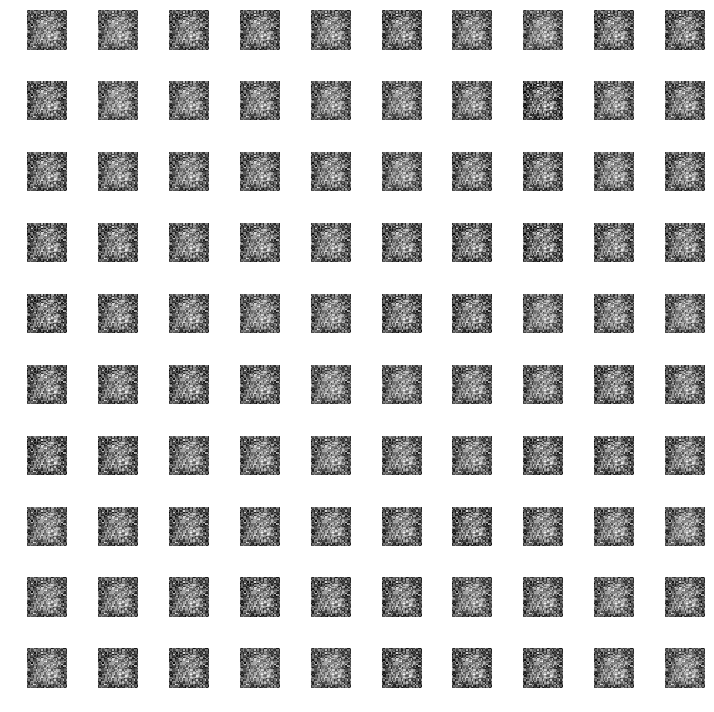

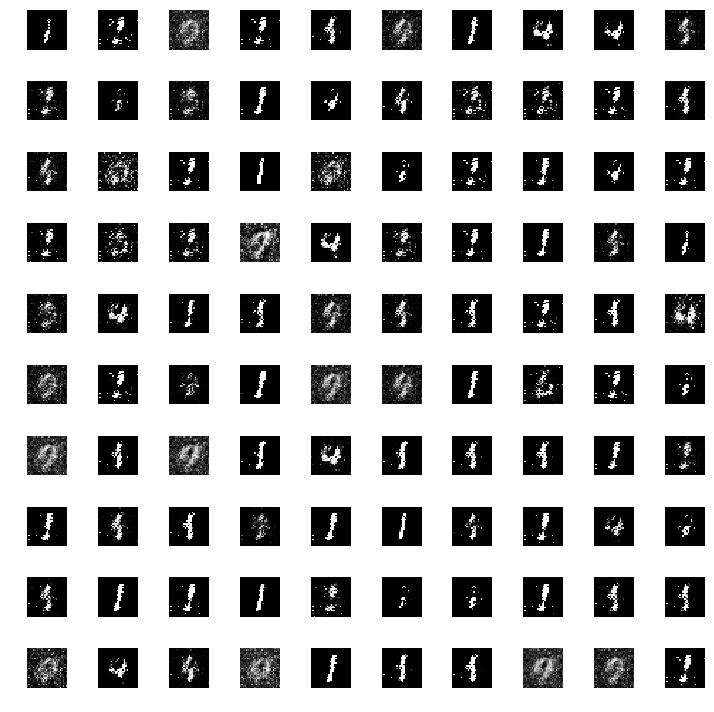

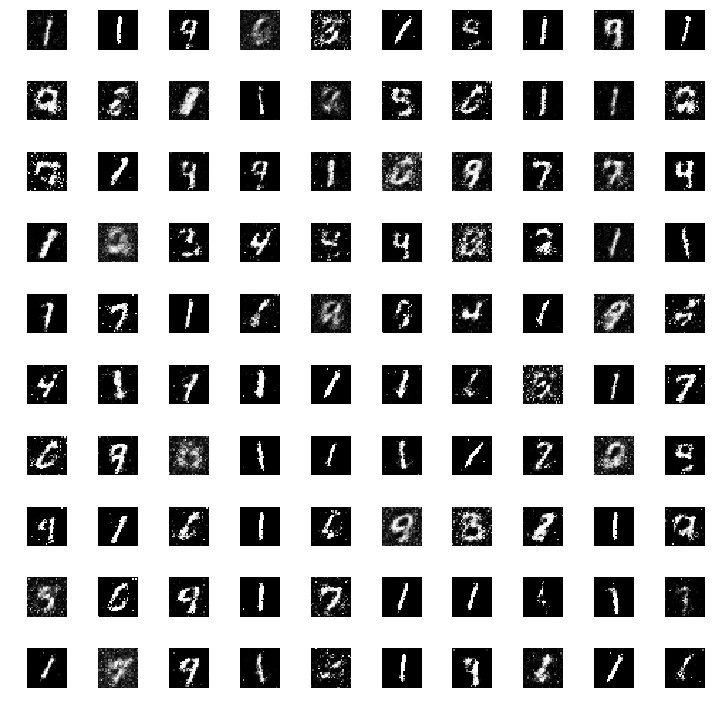

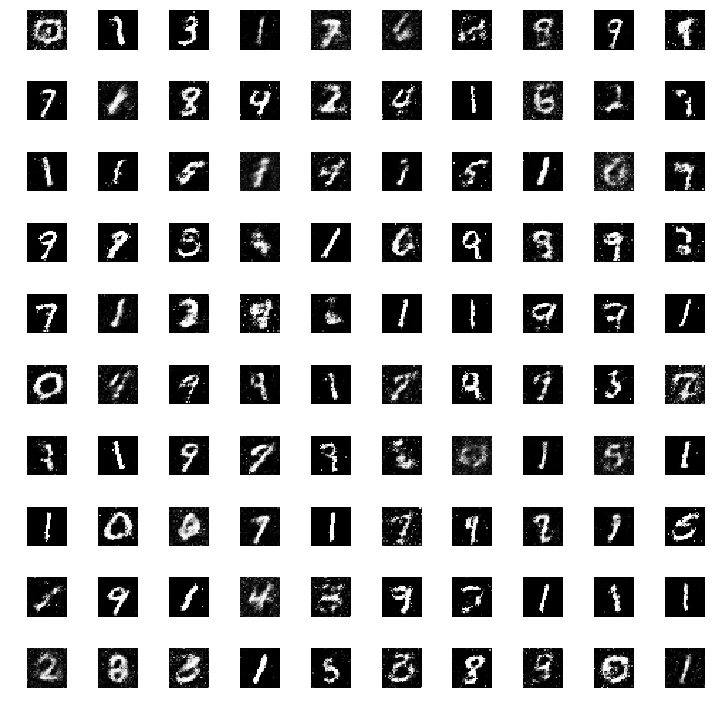

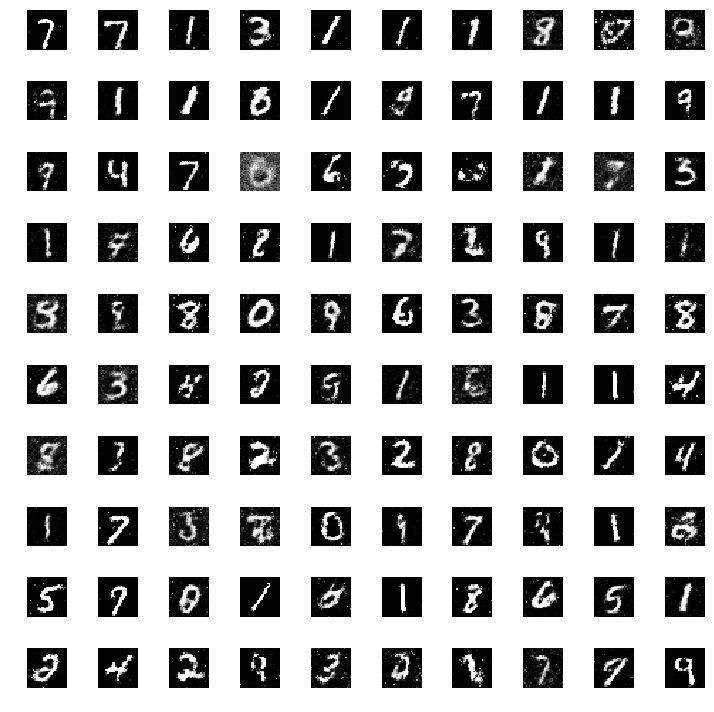

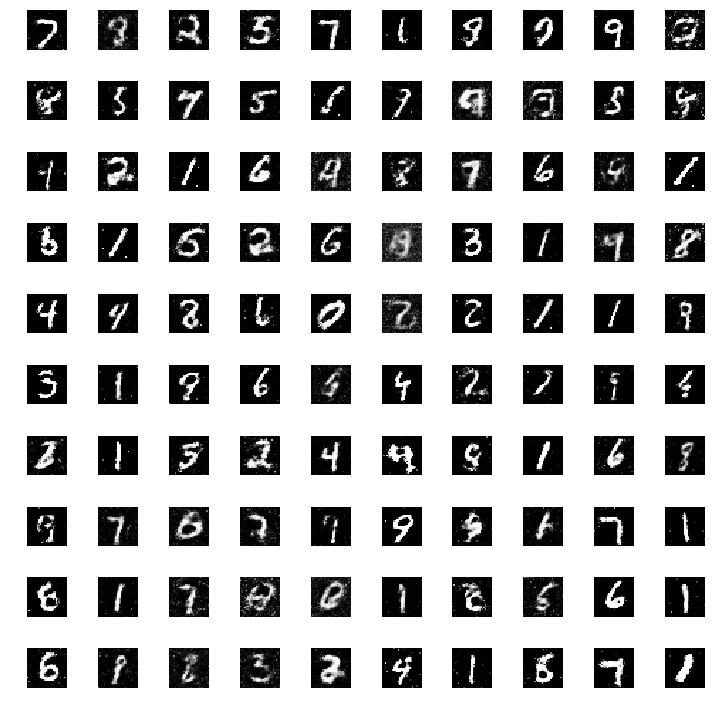

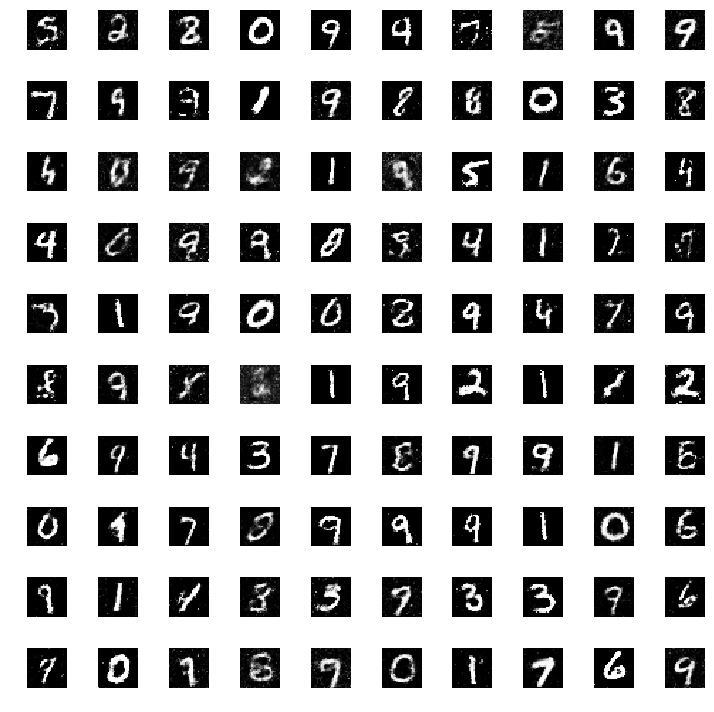

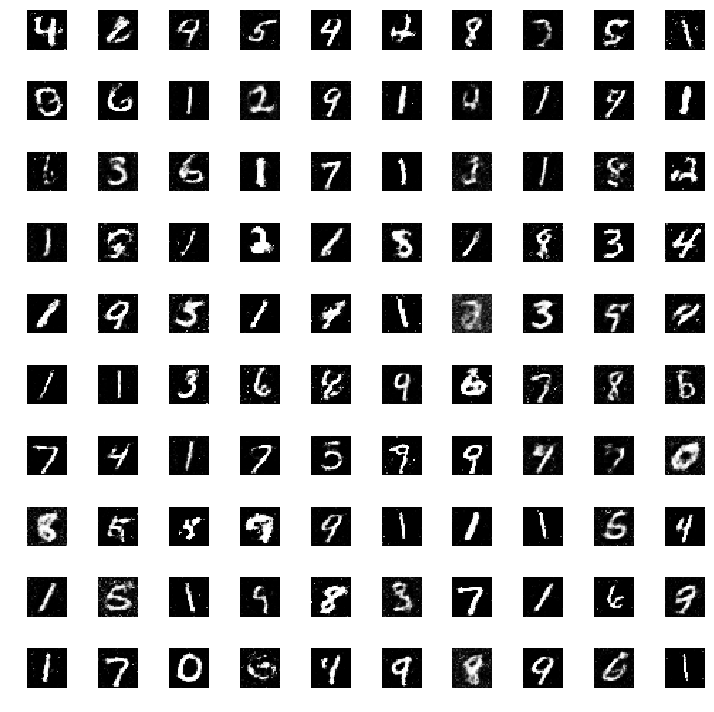

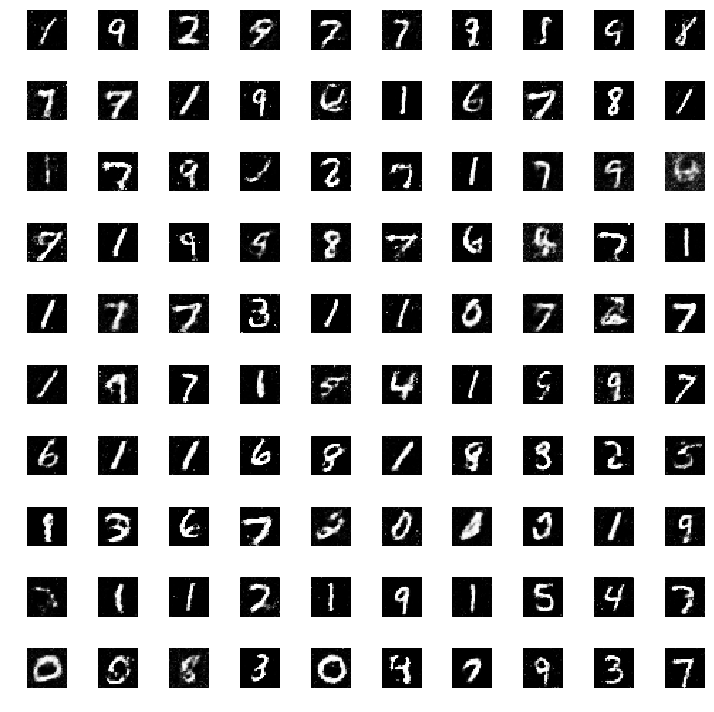

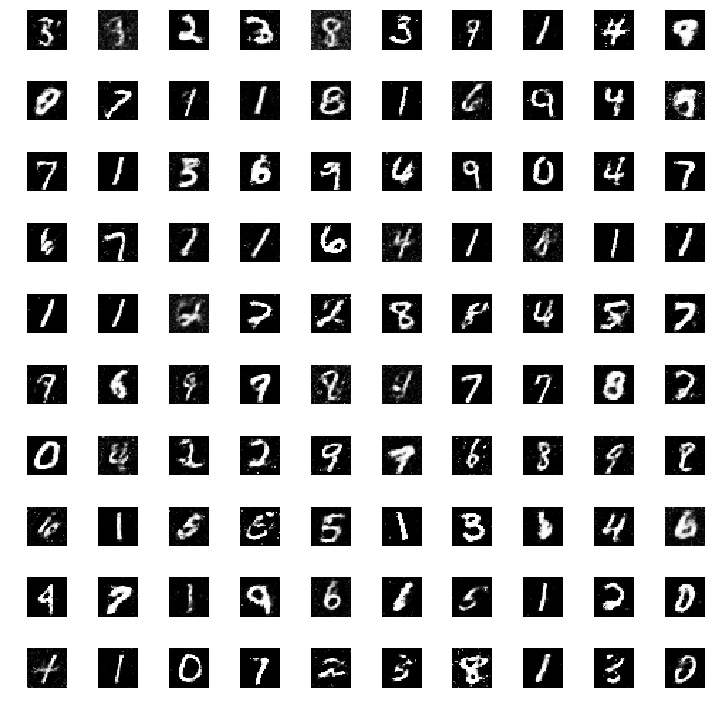

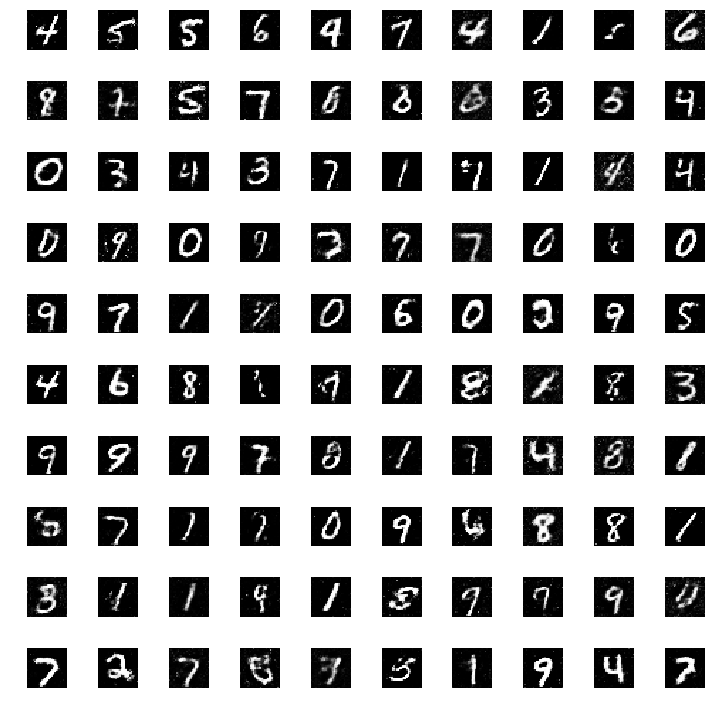

In [7]:
epochs=200
batch_size=128
        
for e in range(1,epochs+1 ):
  print("Epoch %d" %e)
  for _ in tqdm(range(100)): #tqdm just displays a progress bar 

    #generate  random noise as an input  to  initialize the  generator
    noise= np.random.normal(0,1, [batch_size, 100])

    # Generate fake MNIST images from noised input
    generated_images = generator.predict(noise)

    # Get a random set of  real images
    image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]

    #Construct different batches of  real and fake data 
    X= np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis=np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9

    #Pre train discriminator on  fake and real data  before starting the gan. 
    discriminator.trainable=True
    discriminator.train_on_batch(X, y_dis)

    #Tricking the noised input of the Generator as real data
    y_gen = np.ones(batch_size)

    # During the training of gan, 
    # the weights of discriminator should be fixed. 
    #We can enforce that by setting the trainable flag
    discriminator.trainable=False

    #training  the GAN by alternating the training of the Discriminator 
    #and training the chained GAN model with Discriminator’s weights freezed.
    gan.train_on_batch(noise, y_gen)

  if e == 1 or e % 20 == 0:
           
    plot_generated_images(e, generator)



As an illustration of the power of our generator, we will choose two random inputs and produce a sequence of characters that interpolate between them.

In [0]:
noise= np.random.normal(loc=0, scale=1, size=[2,100])

noise_interp=np.zeros((60,100))
for i in range(60):
  t=i/59
  noise_interp[i]=t*noise[0]+(1-t)*noise[1]
  
images = generator.predict(noise_interp)
images = images.reshape(60,28,28)
  

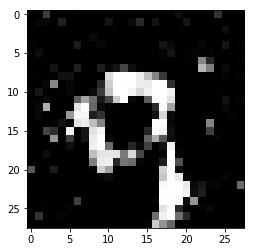

In [9]:
plt.imshow(images[0],cmap='gray')

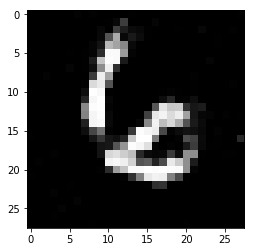

In [10]:
plt.imshow(images[59],cmap='gray')

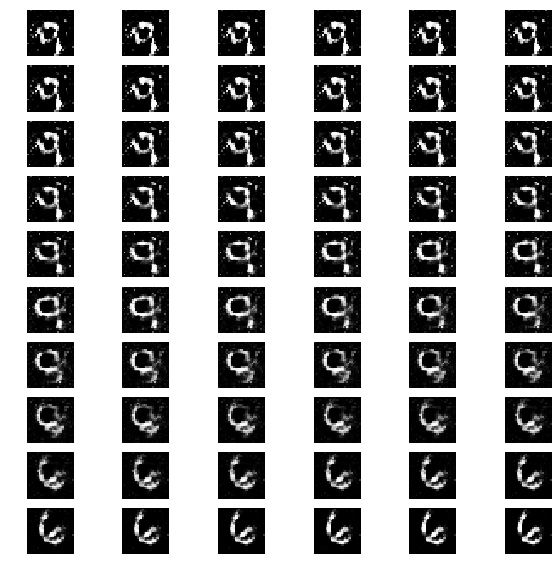

In [11]:
dim=(10,6)
plt.figure(figsize=(10,10))
for i in range(60):
  plt.subplot(dim[0], dim[1], i+1)
  plt.imshow(images[i], cmap='gray')
  plt.axis('off')


# Exercises

##Exercise 1. 

Import the Sign Language MNIST dataset from Kaggle, and train the above GAN on it. When it is done, use OpenCV to output the frames of the final image interpolation to a video file.

In [0]:
## Your code here.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.optimizers import adam

from google.colab import files 

filename = './sign_mnist_train.csv'
sign_mnist_train =pd.read_csv(filename)

filename = './sign_mnist_test.csv'
sign_mnist_test =pd.read_csv(filename)

In [0]:
# x_train = sign_mnist_train.drop(['label'],axis = 1)
x_train = sign_mnist_train.iloc[:,1:]
x_train = (x_train.astype(np.float32) - 127.5)/127.5
y_train = sign_mnist_train['label']
x_train = np.array(x_train)
y_train = np.array(y_train)

In [100]:
generator=Sequential([
    Dense(units=256,input_dim=100,activation='relu'),
    Dense(units=512, activation='relu'),
    Dense(units=1024, activation='relu'),
    Dense(units=784, activation='tanh'),
])

generator.summary()
    
generator.compile(loss='binary_crossentropy', optimizer=adam(lr=0.0002, beta_1=0.5))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_30 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_32 (Dense)             (None, 784)               803600    
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
_________________________________________________________________


In [101]:
##model building
discriminator = Sequential([
    Dense(1024, activation='relu',input_dim=784),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


discriminator.compile(loss='binary_crossentropy', optimizer=adam(lr=0.0002, beta_1=0.5))

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 257       
Total para

In [102]:
#When we train the GAN that we are about to create, we will freeze the parameters of the Discriminator. 
#It is not necessary to do this now, but it will help us determine how many parameters there are at training time.
discriminator.trainable=False 

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_output= discriminator(x)
gan= Model(inputs=gan_input, outputs=gan_output)

gan.summary()

gan.compile(loss='binary_crossentropy', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
def plot_generated_sign_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], cmap='gray', interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_sign_normalized_image %d.png' %epoch)

In [104]:
epochs=300
batch_size=128
        
for e in range(1,epochs+1 ):
  print("Epoch %d" %e)
  for _ in tqdm(range(100)): #tqdm just displays a progress bar 

    #generate  random noise as an input  to  initialize the  generator
    noise= np.random.normal(0,1, [batch_size, 100])

    # Generate fake MNIST images from noised input
    generated_images = generator.predict(noise)

    # Get a random set of  real images
    image_batch =x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]

    #Construct different batches of  real and fake data 
    X= np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis=np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9

    #Pre train discriminator on  fake and real data  before starting the gan. 
    discriminator.trainable=True
    discriminator.train_on_batch(X, y_dis)

    #Tricking the noised input of the Generator as real data
    y_gen = np.ones(batch_size)

    # During the training of gan, 
    # the weights of discriminator should be fixed. 
    #We can enforce that by setting the trainable flag
    discriminator.trainable=False

    #training  the GAN by alternating the training of the Discriminator 
    #and training the chained GAN model with Discriminator’s weights freezed.
    gan.train_on_batch(noise, y_gen)

  if e == 1 or e % 20 == 0:
           
    plot_generated_sign_images(e, generator)

Output hidden; open in https://colab.research.google.com to view.

In [111]:
import cv2
import numpy as np
import os
from os.path import isfile, join
pathIn= '/content/'
pathOut = 'video.mp4'
fps = 1.5

frame_array = []
files = [f for f in os.listdir(pathIn) if 'gan_generated_sign_normalized_image' in f]

#for sorting the file names properly
files.sort(key = lambda x: int(x.split(" ")[1].split(".")[0]))

# print(files)
for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'MP4V'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

['gan_generated_sign_normalized_image 1.png', 'gan_generated_sign_normalized_image 20.png', 'gan_generated_sign_normalized_image 40.png', 'gan_generated_sign_normalized_image 60.png', 'gan_generated_sign_normalized_image 80.png', 'gan_generated_sign_normalized_image 100.png', 'gan_generated_sign_normalized_image 120.png', 'gan_generated_sign_normalized_image 140.png', 'gan_generated_sign_normalized_image 160.png', 'gan_generated_sign_normalized_image 180.png', 'gan_generated_sign_normalized_image 200.png', 'gan_generated_sign_normalized_image 220.png', 'gan_generated_sign_normalized_image 240.png', 'gan_generated_sign_normalized_image 260.png', 'gan_generated_sign_normalized_image 280.png', 'gan_generated_sign_normalized_image 300.png']
